In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import plates

dataDir = '00.1-data/platereader'
files = [os.path.join(dataDir, i) for i in os.listdir(dataDir)]
files

['00.1-data/platereader/2022-03-02-00.1-prot-30deg-mtrx.CSV',
 '00.1-data/platereader/00.1-2022-03-02-plate0-blank.CSV',
 '00.1-data/platereader/2022-03-02-00.1-prot-30degC.CSV',
 '00.1-data/platereader/00.1-2022-03-02-incr-prot-vol.CSV']

In [17]:
test = plates.Plate('00.1-data/platereader/2022-03-02-00.1-prot-30degC.CSV')
ctrl = plates.Plate('00.1-data/platereader/00.1-2022-03-02-plate0-blank.CSV')

In [27]:
from scipy import ndimage

fig, ax = plt.subplots(4,3, figsize=(13,6))

for i in ctrl.df.index:
    x = ctrl.df.loc[i,:]
    ax[0,0].plot(x)
ax[0,0].set_xlim(300,800)
ax[0,0].set_title('ctrl')

for i in ctrl.df.index:
    x = test.df.loc[i,:]
    ax[0,1].plot(x)
ax[0,1].set_xlim(300,800)
ax[0,1].set_title('test')


for i in test.df.index:
    ax[0,2].plot(test.df.loc[i,:] - ctrl.df.loc[i,:])
ax[0,2].xlim(300,800)
ax[0,2].title('test - ctrl')

plt.figure(figsize=(16,6))
for i in test.df.index:
    x = test.df.loc[i,:] - ctrl.df.loc[i,:]
    x -= x.loc[800]
    ax[0,2].plot(x)
ax[0,2].xlim(300,800)
ax[0,2].title('test - ctrl, zero 800')

plt.figure(figsize=(16,6))
for i in test.df.index:
    x = test.df.loc[i,:] - ctrl.df.loc[i,:]
    x -= ndimage.gaussian_filter(x.loc[800], 3)
    ax[0,2].plot(x)
ax[0,2].xlim(300,800)
ax[0,2].title('test - ctrl, zero 800 - smoothed')
plt.tight_layout()

plt.show()

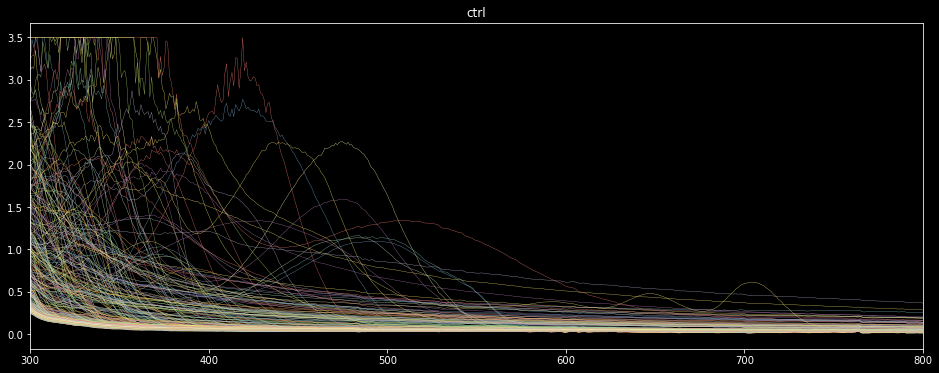

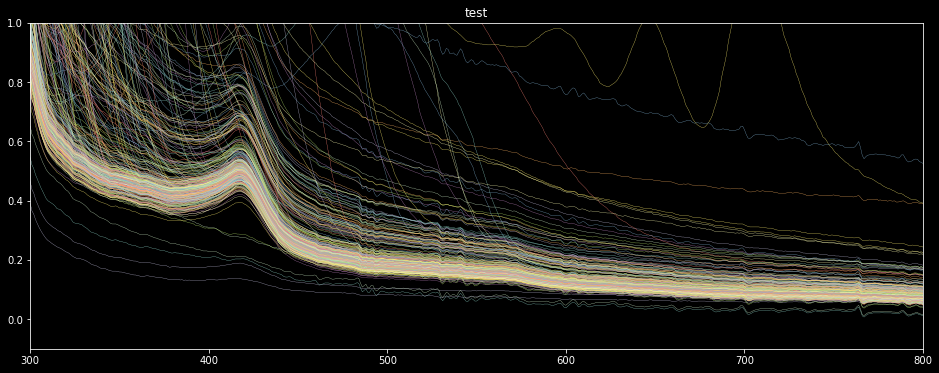

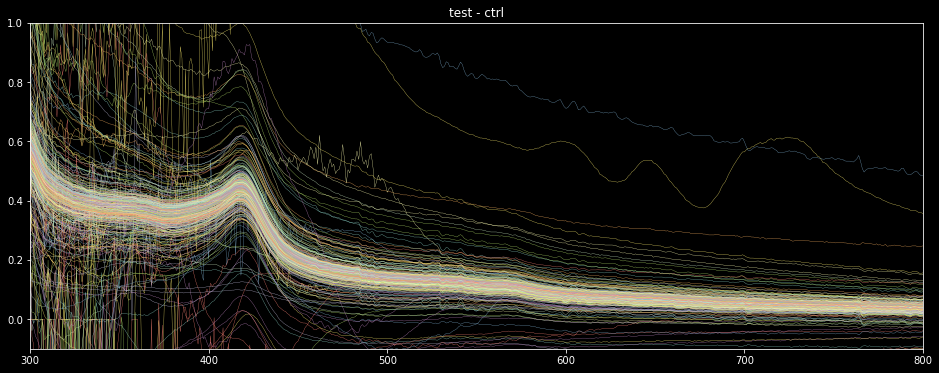

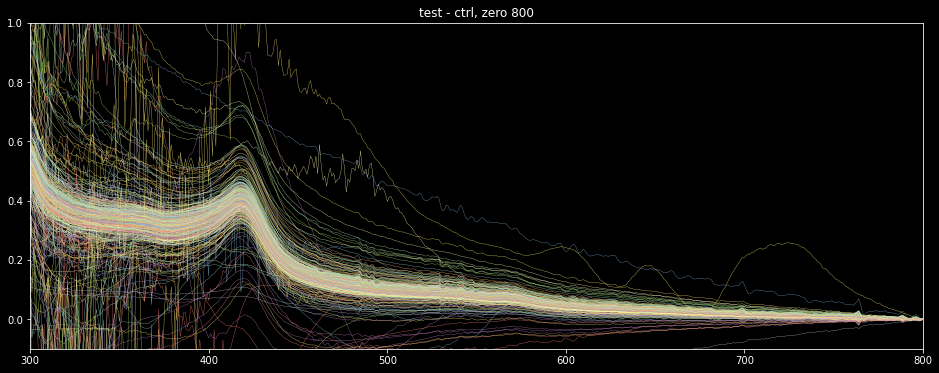

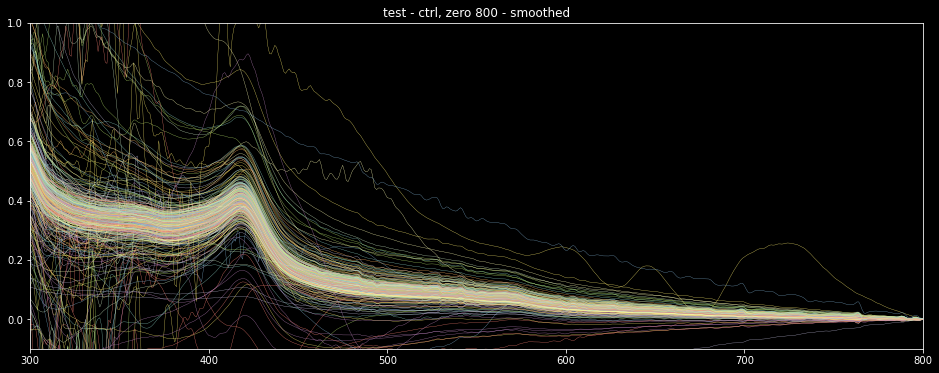

In [51]:
from scipy import ndimage

plt.figure(figsize=(16,6))
for i in ctrl.df.index:
    plt.plot(ctrl.df.loc[i,:], lw=0.3)
plt.xlim(300,800)
plt.title('ctrl')
plt.show()


plt.figure(figsize=(16,6))
for i in test.df.index:
    plt.plot(test.df.loc[i,:], lw=0.3)
plt.xlim(300,800)
plt.ylim(-0.1,1)
plt.title('test')
plt.show()

plt.figure(figsize=(16,6))
for i in test.df.index:
    plt.plot(test.df.loc[i,:] - ctrl.df.loc[i,:], lw=0.3)
plt.xlim(300,800)
plt.ylim(-0.1,1)
plt.title('test - ctrl')
plt.show()

plt.figure(figsize=(16,6))
for i in test.df.index:
    x = test.df.loc[i,:] - ctrl.df.loc[i,:]
    x -= x.loc[800]
    plt.plot(x, lw=0.3)
plt.xlim(300,800)
plt.ylim(-0.1,1)
plt.title('test - ctrl, zero 800')
plt.show()

plt.figure(figsize=(16,6))
for i in test.df.index:
    x = test.df.loc[i,:] - ctrl.df.loc[i,:]
    x -= x.loc[800]
    x = x.dropna()
    x = pd.Series(ndimage.gaussian_filter1d(x, 1), index=x.index)
    plt.plot(x, lw=0.3)
plt.xlim(300,800)
plt.ylim(-0.1,1)
plt.title('test - ctrl, zero 800 - smoothed')
plt.show()

In [34]:
x = test.df.loc[i,:] - ctrl.df.loc[i,:]
x -= x.loc[800]
xs = ndimage.gaussian_filter1d(x, 1)
x

220      NaN
221      NaN
222      NaN
223      NaN
224      NaN
       ...  
796    0.000
797   -0.002
798   -0.003
799   -0.003
800    0.000
Name: P24, Length: 581, dtype: float64

In [48]:
ndimage.gaussian_filter1d(x,2)

array([ 4.69206594e-01,  4.64594657e-01,  4.56346679e-01,  4.45872951e-01,
        4.34450751e-01,  4.22987953e-01,  4.12060145e-01,  4.02033866e-01,
        3.93146118e-01,  3.85488048e-01,  3.78949999e-01,  3.73255663e-01,
        3.68117410e-01,  3.63385344e-01,  3.59062306e-01,  3.55198596e-01,
        3.51782091e-01,  3.48714412e-01,  3.45862072e-01,  3.43109566e-01,
        3.40377015e-01,  3.37635206e-01,  3.34939732e-01,  3.32434704e-01,
        3.30269585e-01,  3.28471002e-01,  3.26891192e-01,  3.25299795e-01,
        3.23543505e-01,  3.21632757e-01,  3.19705718e-01,  3.17936770e-01,
        3.16457686e-01,  3.15307352e-01,  3.14418675e-01,  3.13653580e-01,
        3.12868278e-01,  3.11978537e-01,  3.10995836e-01,  3.10005075e-01,
        3.09088541e-01,  3.08263539e-01,  3.07497430e-01,  3.06772739e-01,
        3.06110919e-01,  3.05521820e-01,  3.04957197e-01,  3.04347450e-01,
        3.03675359e-01,  3.02986375e-01,  3.02336557e-01,  3.01759119e-01,
        3.01276205e-01,  